# CANMEX-REPCOL

In [1]:
import pandas as pd
import os
from azure.storage.blob import BlobServiceClient
import gzip
import json
import string
import re
import numpy as np
import nltk
import openpyxl
import pyarrow
import fastparquet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
# from sklearn.feature_extraction.text import TfidfVectorizer

# Importing local modules
from data_ingestion import download_and_create_df

nltk.download('stopwords') # Directly download the necessary data for further cleaning

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aneur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Retrieve environment variables
storage_account = os.environ.get("STORAGE_ACCOUNT")
container = os.environ.get("CONTAINER")
sas_token = os.environ.get("ADLS_SAS_TOKEN")
sas_url = os.environ.get("SAS_URL")

In [3]:
account_url = f"https://{storage_account}.blob.core.windows.net"
service_client = BlobServiceClient(account_url=account_url, credential=sas_token)

# Access the container
container_client = service_client.get_container_client(container)

In [4]:
blob_list = list(container_client.list_blobs())

# Create two lists corresponding to each dataset's downloadable data
amazon_metadata = []
amazon_reviews = []
for blob in blob_list:
    blob_name = blob['name']
    if blob_name.endswith('.json.gz'):
        if 'amazon_metadata' in blob_name:
            amazon_metadata.append(blob_name)
        elif 'amazon_reviews' in blob_name:
            amazon_reviews.append(blob_name)

In [5]:
len(amazon_reviews)

5230

In [6]:
# Use the function to download the files and create the DataFrames
df_metadata = download_and_create_df(amazon_metadata[0:50], container_client)
df_metadata

,also_buy,also_view,asin,brand,category,date,description,details,feature,fit,image,main_cat,price,rank,similar_item,tech1,tech2,title
0,[],[],6305121869,Ninasill_Blouse,"[Clothing, Shoes & Jewelry, Women, Clothing, T...","<div class=""a-fixed-left-grid a-spacing-none"">...",[(=^ ^=) 1.It is made of high quality material...,{},"[Import, Versatile Occasions - Great for Daily...",,[https://images-na.ssl-images-amazon.com/image...,Movies & TV,$9.99 - $12.50,[],,,,"Women Blouse, Ninasill Hooded Sweatshirt Coat ..."
1,[],[],6318708057,Coolred-Women,"[Clothing, Shoes & Jewelry, Traditional & Cult...","<div class=""a-fixed-left-grid a-spacing-none"">...","[<b><br>Hi friend, welcome to our store. Befor...",{},"[100% Spandex, Order Larger If You are Between...",,[https://images-na.ssl-images-amazon.com/image...,"<img src=""https://images-na.ssl-images-amazon....",$16.08 - $18.36,"14,082,777 in Clothing, Shoes & Jewelry (",,,,Coolred-Women Retro Split Sexy Skinny Premium ...
2,[],"[B07CRJ95M7, B008AHISU4, B07B8F98W2, B07DD98Q7...",6342506256,Gaok,"[Clothing, Shoes & Jewelry, Men, Clothing, Sho...","<div class=""a-fixed-left-grid a-spacing-none"">...",[Gaok men's pants are all made from cotton mat...,{},"[Cotton, Zipper closure, Material:100% cotton,...","class=""a-normal a-align-center a-spacing-smal...",[https://images-na.ssl-images-amazon.com/image...,"<img src=""https://images-na.ssl-images-amazon....",$26.99,"2,877,972 in Clothing, Shoes & Jewelry (",,,,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...
3,"[B077GQQKRV, B07CBJQTF6, B07H2Z6S9J, B06Y26PZ5...","[B07H2Z6S9J, B077GQQKRV, B072XTTTK9, B002DMJOC...",6342509379,QIBOE,"[Clothing, Shoes & Jewelry, Men, Clothing, Jea...","<div class=""a-fixed-left-grid a-spacing-none"">...",[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,{},"[Denim, Zipper closure, Material: cotton, Styl...","class=""a-normal a-align-center a-spacing-smal...",[https://images-na.ssl-images-amazon.com/image...,"<img src=""https://images-na.ssl-images-amazon....",$38.99,"1,506,383 in Clothing, Shoes & Jewelry (",,,,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...
4,[],[B00V6F372G],6342522081,OLO,"[Clothing, Shoes & Jewelry, Women, Accessories...",,[All of our sunglasses offer protection agains...,{'ASIN: ': '6342522081'},"[Material: Polycarbonate, Main features: Windp...",,[https://images-na.ssl-images-amazon.com/image...,Sports & Outdoors,$3.29,"936,295 in Sports & Outdoors (",,,,Crazy Explosion-proof Lens Polarized Sunglasse...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,[],"[B003UESNB6, B003UESNAM, B00AAV738G, B003UESND...",B00PDDGNOQ,Petmate,"[Pet Supplies, Dogs, Collars, Harnesses & Leas...",,[The Aspen Pet Walkabout Retractable Leash off...,{' Product Dimensions: ': '8 x 4.5 x ...,[The Aspen Pet Walkabout Retractable Leash off...,,[],Pet Supplies,$19.80,"206,115 in Pet Supplies (","class=""a-bordered a-horizontal-stripes a-spa...",,,Petmate Walkabout Cord
499996,[],[],B00PDDPEUU,Boots& Barkley,"[Pet Supplies, Dogs, Apparel & Accessories, Bo...",,[coach canine costume Size X Large Fits pets 1...,{' Product Dimensions: ': '8 x 0.5 x ...,"[Pullover t-shirt, Available in sizes XS-XL, I...",,[],Pet Supplies,$14.99,"520,484 in Pet Supplies (","class=""a-bordered a-horizontal-stripes a-spa...",,,Pet Coach Canine Costume
499997,[],[],B00PDE2MR2,Boots and Barkley,"[Pet Supplies, Dogs, Apparel & Accessories, Bo...",,[Coach Canine Dog Pet Tee Shirt Costume Large ...,{' Product Dimensions: ': '16.6 x 8.2...,[],,[],Pet Supplies,$15.00,"579,287 in Pet Supplies (",,,,Coach Canine Dog Pet Tee Shirt Costume Large
499998,[],[],B00PDEG494,Boots and Barkley,"[Pet Supplies, Dogs, Apparel & Accessories, Bo...",,[Coach Canine Dog Pet Tee Shirt Costume Medium...,{' Product Dimensions: ': '9.1 x 6.1 ...,"[Fits dogs up to 50 lbs, Length: 18"", Girth: 1...",,[],Pet Supplies,$15.99,"601,443 in Pet Supplies (",,,,Coach Canine Dog Pet Tee Shirt Costume Medium


In [7]:
def clean_text(raw):
    if isinstance(raw, str):
        # remove HTML tags
        cleantext = re.sub('<.*?>', '', raw)
        # remove special characters
        cleantext = re.sub('[^A-Za-z0-9 ]+', '', cleantext)
        return cleantext
    else:
        return raw  # return original value if it's not a string

# Apply the function to the DataFrame
# df_metadata = df_metadata.applymap(clean_text)
# df_metadata.to_csv("df_metadata_extract.csv")

In [8]:
df_reviews = download_and_create_df(amazon_reviews[0:50], container_client)
df_reviews

,asin,overall,reviewText,reviewerID,reviewerName,summary,unixReviewTime,verified,style,vote,image
0,B00005QDPX,5,Crazy Taxi is by far one of the best video gam...,A36TDX8DY2XK5Q,Some Kid,It's Party Time! Let's Have Some Fun!,1054252800,false,NaN,NaN,NaN
1,B000MXIMKK,4,I love these pants!\n\nFor those of us who sla...,AZZ1YPRM2FAUH,David Colgrove,"Durable, good looking slacks at a reasonable p...",1459900800,true,"{""Size:"":"" 33W x 30L"",""Color:"":"" Graphite""}",6.0,NaN
2,B00005QDPX,2,Anyone who hasn't played this game should rent...,A3PASG15BRR40D,SleepyJD,A fun game that gets old too quickly,1049414400,false,NaN,NaN,NaN
3,B000MXIMKK,5,Great pants and nice crease.,A388UHKJN07JJT,TJK,Great Product,1459900800,true,"{""Size:"":"" 42W x 30L"",""Color:"":"" Black""}",NaN,NaN
4,B00005QDPX,4,In this game you choose a driver and car then ...,A29YLR71A42A3N,Amazon Customer,Fun and Entertaining,1040860800,false,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1342387,1846684250,5,"excellent read, timely transaction, packaging ...",AGRP70U6ZEA0X,Russell Echelbarger,Five Stars,1434067200,true,"{""Format:"":"" Kindle Edition""}",NaN,NaN
1342388,B00KBZOJDS,4,"For the price, thy're OK.",A1CBLEJLAIEHTT,Thomas Stumpfig,Four Stars,1440374400,true,"{""Size:"":"" X-Large"",""Color:"":"" Navy""}",NaN,NaN
1342389,1846684250,3,Very interesting that things have not changed ...,AL2ZOWLOM48PT,Lynda SSD,have not been able to read the entire book yey...,1431388800,true,"{""Format:"":"" Paperback""}",NaN,NaN
1342390,B00KBZOJDS,5,Nice fit and good quality,A1G6YDEKFVJSC4,virginia,Five Stars,1440374400,true,"{""Size:"":"" 3X-Large"",""Color:"":"" White""}",NaN,NaN


In [9]:
df_reviews.isnull().sum()

asin                    0
overall                 0
reviewText           1104
reviewerID              0
reviewerName          190
summary               585
unixReviewTime          0
verified                0
style              259990
vote              1147918
image             1321648
dtype: int64

# Feature engineering & EDA

In [10]:
stopwords = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(text):
    """
    Function to remove punctuation characters, stopwords.
    """
    text = "".join([word.lower() for word in text if word not in stopwords and word not in punctuation])
    return text

In [11]:
# Clean text (Et 2 mins)
df_reviews['summary2'] = df_reviews['summary'].apply(lambda x: clean_text(str(x)))
df_reviews['reviewText2'] = df_reviews['reviewText'].apply(lambda x: clean_text(str(x)))

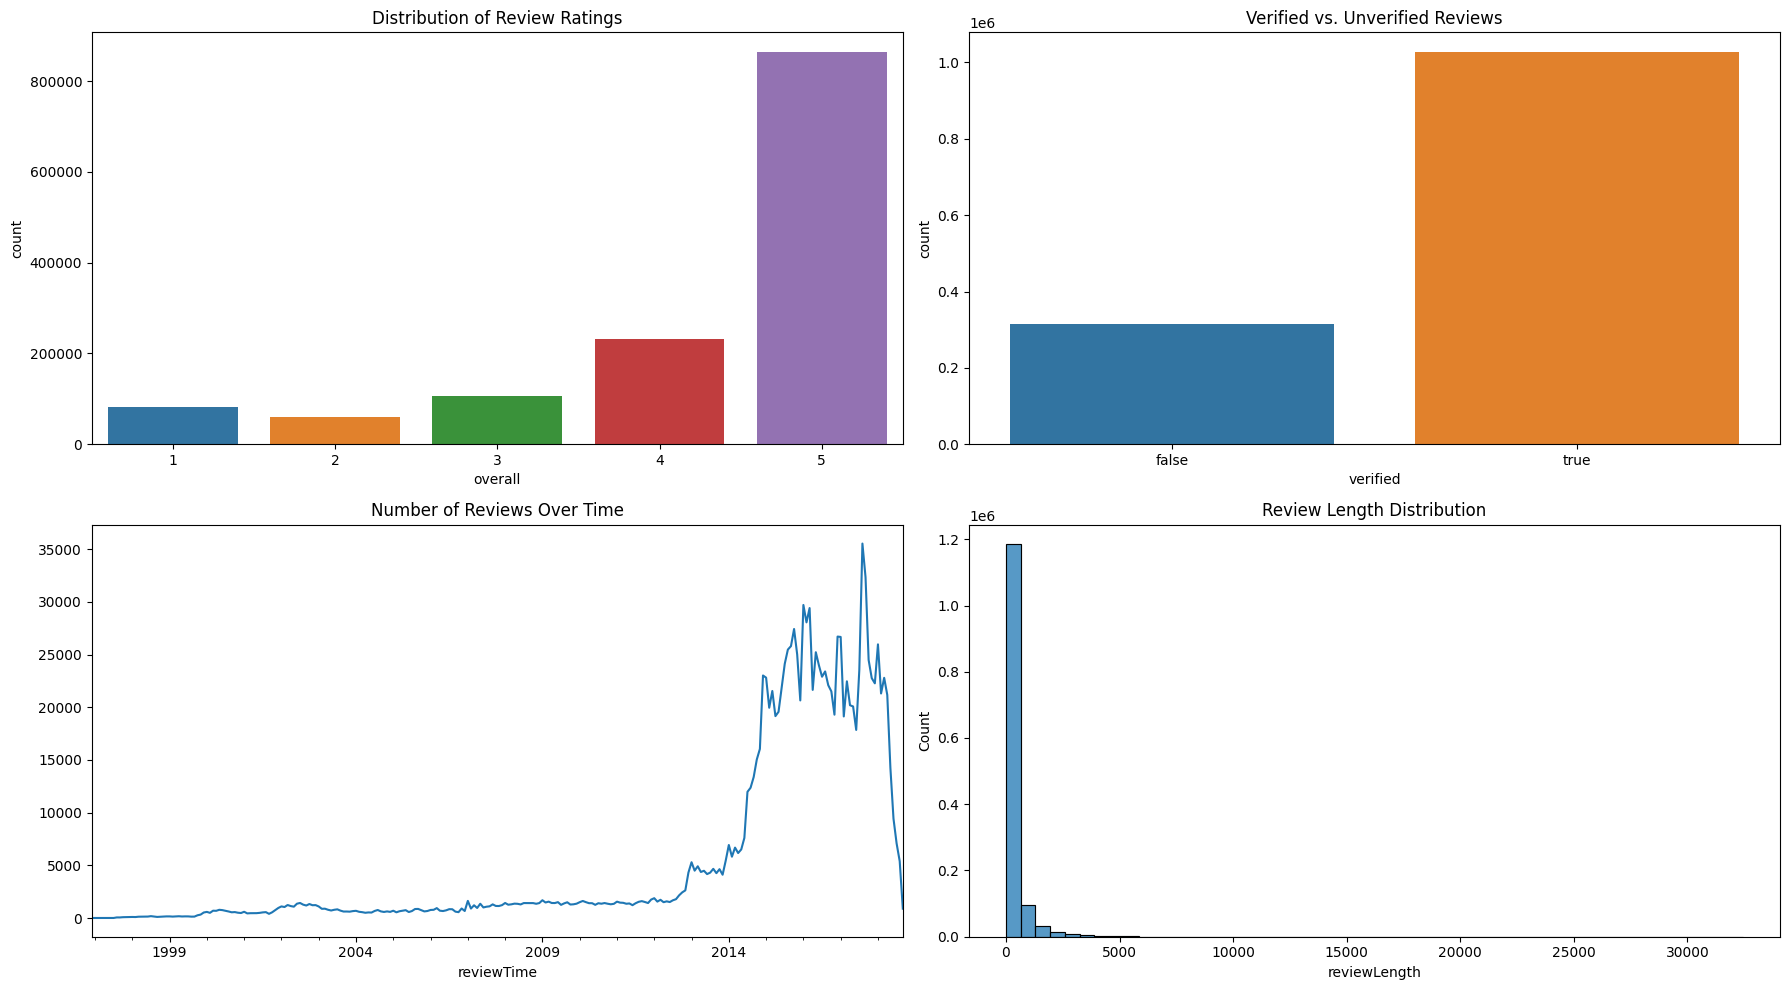

In [12]:
# Feature engineering
df_reviews['reviewText'] = df_reviews['reviewText'].apply(str)
df_reviews['reviewLength'] = df_reviews['reviewText'].apply(len)
df_reviews['reviewCount'] = df_reviews.groupby('reviewerID')['reviewerID'].transform('count')
df_reviews['uniqueProducts'] = df_reviews.groupby('reviewerID')['asin'].transform('nunique')
df_reviews['reviewLength'] = df_reviews['reviewText'].str.len()
df_reviews['reviewTime'] = pd.to_datetime(df_reviews['unixReviewTime'], unit='s') # Reformat the date column

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
sns.countplot(data=df_reviews, x='overall', ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Review Ratings')
sns.countplot(data=df_reviews, x='verified', ax=axs[0, 1])
axs[0, 1].set_title('Verified vs. Unverified Reviews')
df_reviews.resample('M', on='reviewTime')['reviewText'].count().plot(ax=axs[1, 0])
axs[1, 0].set_title('Number of Reviews Over Time')
sns.histplot(data=df_reviews, x='reviewLength', bins=50, ax=axs[1, 1])
axs[1, 1].set_title('Review Length Distribution')
plt.tight_layout()
plt.show()

In [13]:
num_reviewers = df_reviews['reviewerID'].nunique() # Number of reviewers
num_products = df_reviews['asin'].nunique() # Unique number of products
num_reviewers, num_products

(1117574, 150907)

In [14]:
df_merged = pd.merge(df_reviews, df_metadata, on='asin', how='inner')
df_merged.shape

(635, 34)

In [15]:
df_merged['reviewText_sentiment'] = df_merged['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) # Get a quick sentiment score of reviewText
df_merged['summary_sentiment'] = df_merged['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) # Get a quick sentiment score of summary

Only keep the last 5 years in the dataset `df_merged`.

In [16]:
max_date = df_merged['reviewTime'].max()
five_years_ago = max_date - pd.DateOffset(years=5)
df_merged = df_merged[df_merged['reviewTime'] >= five_years_ago]
df_merged.shape

(635, 36)

Get a global sense of the column `price`: when there is more than a single number in the column get the average of the two.

In [17]:
df_merged.price.unique()

array(['$15.99 - $17.87', '', '$11.99 - $14.99', '$6.44 - $27.97',
       '$8.99 - $21.22'], dtype=object)

In [18]:
df_merged['price'] = df_merged['price'].astype(str).replace(' +', ' ', regex=True)
df_merged['price'] = df_merged['price'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df_merged[['price_low', 'price_high']] = df_merged['price'].str.split(' - ', expand=True)
df_merged[['price_low', 'price_high']] = df_merged[['price_low', 'price_high']].apply(pd.to_numeric, errors='coerce')
df_merged['average_price'] = df_merged[['price_low', 'price_high']].mean(axis=1)
df_merged['average_price'] = np.where((df_merged['average_price']==0) | (df_merged['average_price']==""), 
                                      df_merged['price'], df_merged['average_price'])
df_merged['average_price'] = df_merged['average_price'].fillna(0).astype(int)

In [19]:
df_merged[['price','price_low','price_high','average_price']] # Cleaning operations applied to price

,price,price_low,price_high,average_price
0,15.99 - 17.87,15.99,17.87,16
1,15.99 - 17.87,15.99,17.87,16
2,15.99 - 17.87,15.99,17.87,16
3,15.99 - 17.87,15.99,17.87,16
4,15.99 - 17.87,15.99,17.87,16
...,...,...,...,...
630,,NaN,NaN,0
631,,NaN,NaN,0
632,,NaN,NaN,0
633,,NaN,NaN,0


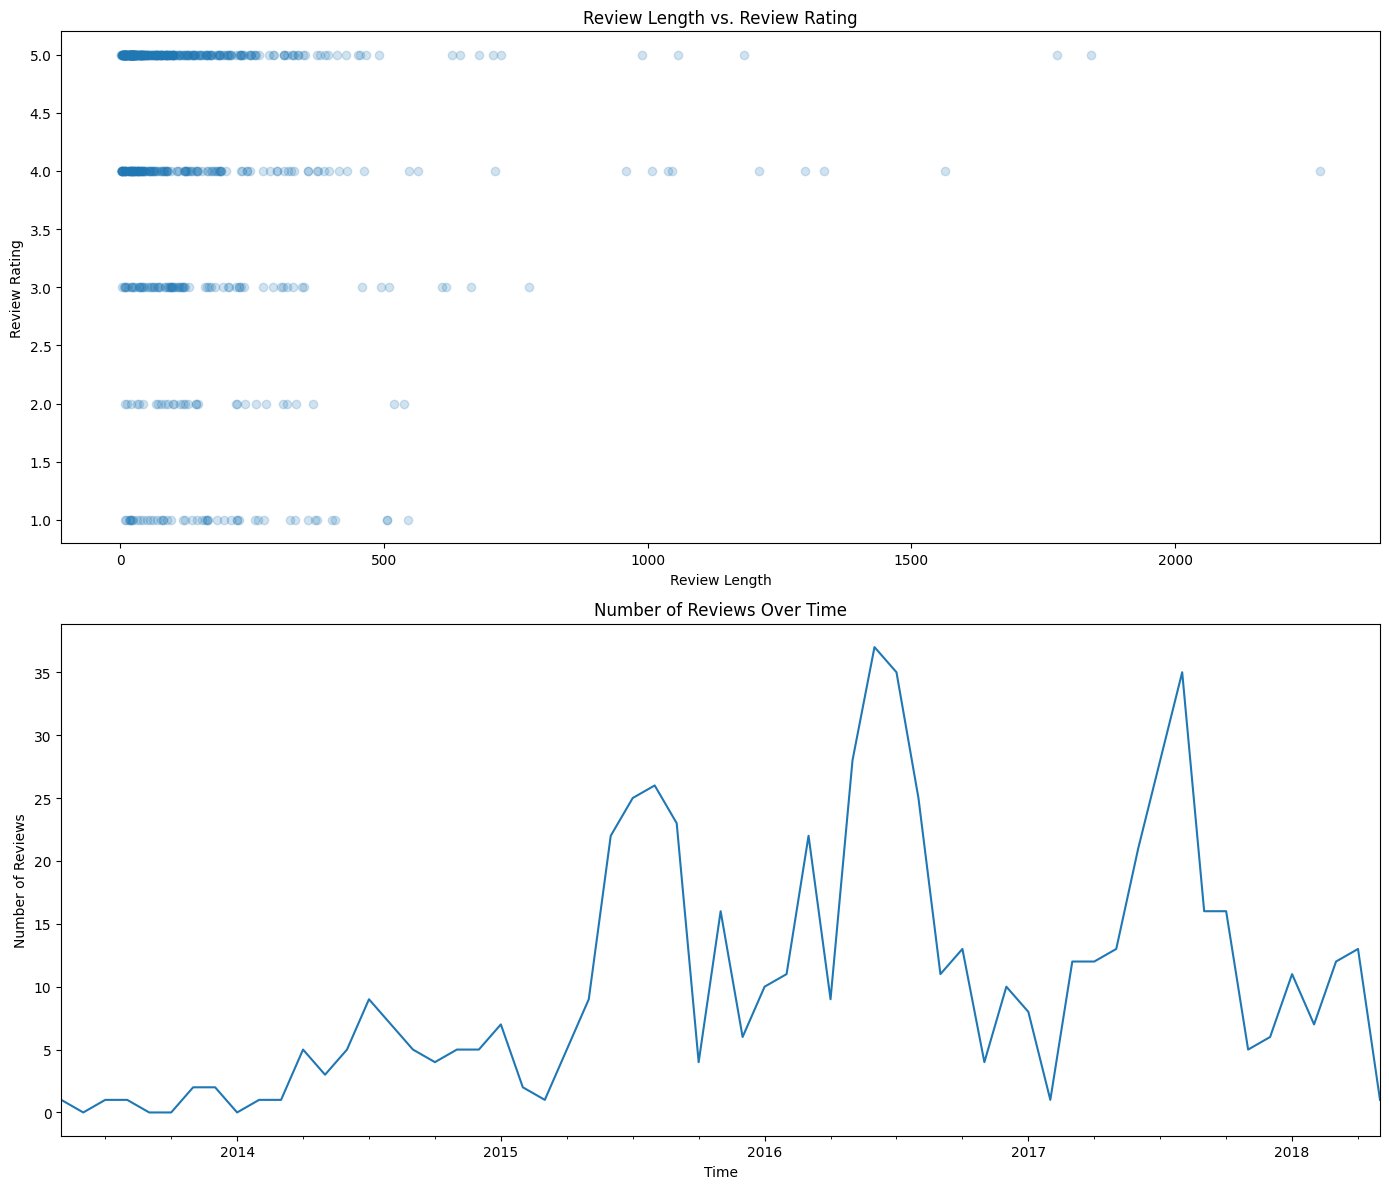

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(14, 12))
axs[0].scatter(df_merged['reviewLength'], df_merged['overall'], alpha=0.2) # Comparison of length vs rating
axs[0].set_title('Review Length vs. Review Rating')
axs[0].set_xlabel('Review Length')
axs[0].set_ylabel('Review Rating')
df_merged.resample('M', on='reviewTime')['reviewText'].count().plot(ax=axs[1])
axs[1].set_title('Number of Reviews Over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

## Sentiment score feature plot

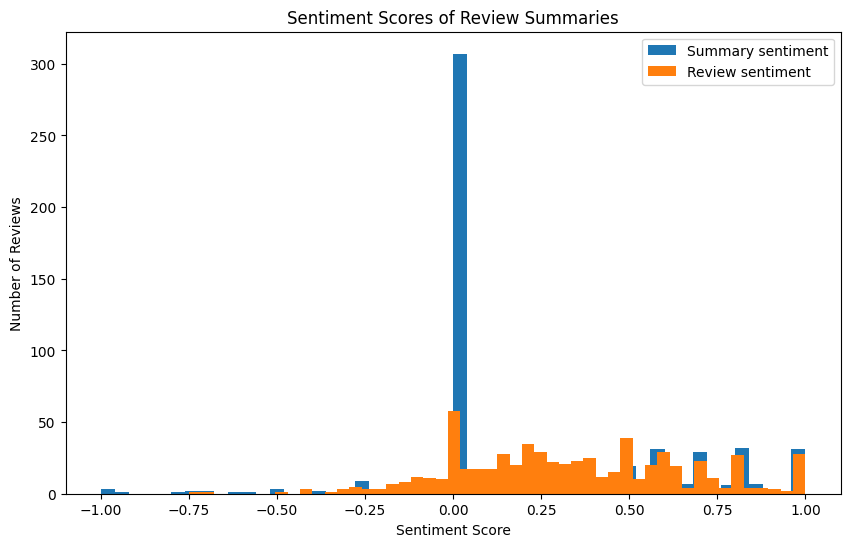

In [21]:
# Plot a histogram of the sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(df_merged['summary_sentiment'], bins=50, label="Summary sentiment")
plt.hist(df_merged['reviewText_sentiment'], bins=50, label="Review sentiment")
plt.title('Sentiment Scores of Review Summaries')
plt.legend()
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

# Client segmentation clustering model experiment

In [22]:
# For the kmeans experiment, add additional features regarding the current season as it was 
# identified that during summer there is a higher review count overall

In [23]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

df_merged['season'] = df_merged['reviewTime'].dt.month.apply(get_season)
season_mapping = {'Spring': 1.0, 'Summer': 2.0, 'Autumn': 3.0, 'Winter': 4.0}
df_merged['season'] = df_merged['season'].map(season_mapping)
df_merged

,asin,overall,reviewText,reviewerID,reviewerName,summary,unixReviewTime,verified,style,vote,...,similar_item,tech1,tech2,title,reviewText_sentiment,summary_sentiment,price_low,price_high,average_price,season
0,B0007RAE7A,5,This is a beautifully constructed short sleeve...,A2OCDK0BOW6UCY,Antigone Walsh,Handsome,1440633600,false,"{""Size:"":"" X-Large"",""Color:"":"" Biking Red""}",NaN,...,,,,Wrangler Authentics Men's Short-Sleeve Classic...,0.315000,0.50000,15.99,17.87,16,2.0
1,B0007RAE7A,5,Nice shirt and fast service,A3CNV8UGYS3YSF,Edward J,Five Stars,1440374400,true,"{""Size:"":"" Large"",""Color:"":"" Caviar""}",NaN,...,,,,Wrangler Authentics Men's Short-Sleeve Classic...,0.400000,0.00000,15.99,17.87,16,2.0
2,B0007RAE7A,5,Very good !!,AEA81GRAJRXZ7,teknicom,Five Stars,1440201600,true,"{""Size:"":"" 3X"",""Color:"":"" Caviar""}",NaN,...,,,,Wrangler Authentics Men's Short-Sleeve Classic...,1.000000,0.00000,15.99,17.87,16,2.0
3,B0007RAE7A,5,WOW!\nThese shirts are great looking and fitti...,A1DUU6X9908XON,TopangaRose,WOW! These shirts have everything!,1440115200,true,"{""Size:"":"" X-Large"",""Color:"":"" Caviar""}",NaN,...,,,,Wrangler Authentics Men's Short-Sleeve Classic...,0.523611,0.15625,15.99,17.87,16,2.0
4,B0007RAE7A,4,"Everything's great, but wish I'd done more sh...",A2AIHAAWTI58X3,Earl Churchwell,Good stuff,1439769600,true,"{""Size:"":"" 2X"",""Color:"":"" Caviar""}",NaN,...,,,,Wrangler Authentics Men's Short-Sleeve Classic...,0.900000,0.70000,15.99,17.87,16,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,B00EZIC2E0,3,"too small, sent them back.",A10HINYET5C2EJ,Nancy,Three Stars,1405814400,false,"{""Size:"":"" 9 B(M) US"",""Color:"":"" Ivory""}",NaN,...,,,,Naturalizer Women's Ulysses Ballet Flat,-0.125000,0.00000,NaN,NaN,0,2.0
631,B00EZIC2E0,2,"My feet are size 11.5, but the size 12 was too...",A213IJYB1QEHJY,Amazon Customer,Not recommended by me,1399420800,true,"{""Size:"":"" 12 B(M) US"",""Color:"":"" Gold""}",NaN,...,,,,Naturalizer Women's Ulysses Ballet Flat,0.187500,0.00000,NaN,NaN,0,1.0
632,B00EZIC2E0,2,"Two stars for style, but fit gets -0. Way too...",AW12R2FU6RISI,shoe collector,Another Naturalizer disappointment,1398211200,false,NaN,2.0,...,,,,Naturalizer Women's Ulysses Ballet Flat,0.050000,-0.60000,NaN,NaN,0,1.0
633,B00EZIC2E0,5,I had foot surgery in the fall and have ended ...,A39P311DQA8B8,Susan A,Adorable spring shoe,1397606400,false,NaN,2.0,...,,,,Naturalizer Women's Ulysses Ballet Flat,0.308333,0.50000,NaN,NaN,0,1.0


In [28]:
df_merged.to_parquet("app/df_merged.parquet", index=False)

In [26]:
import plotly.graph_objects as go
import nbformat
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Select the features
features = df_merged[['overall','reviewText_sentiment','summary_sentiment','average_price','season']]

# Apply the t-SNE transformation
tsne = TSNE(n_components=3, random_state=0)
tsne_results = tsne.fit_transform(features)

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    z=tsne_results[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=df_merged['overall'], # set color to season
        colorscale='Viridis', # choose a colorscale
        colorbar=dict(title="Seasons"), # colorbar title
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()